Читаем файл


In [5]:
with open('SMSSpamCollection.txt') as f:
  file_lines = f.readlines()
print(f"Line's count: {len(file_lines)}")

Line's count: 5574


Парсим строки

In [25]:
SPAM = 'spam'
NOT_SPAM = 'not_spam'
parsed_lines = {SPAM: [], NOT_SPAM: []}
for line in file_lines:
  splitted_line = line.split(maxsplit=1)
  key = splitted_line[0] if splitted_line[0] != 'ham' else NOT_SPAM # хз что такое ham, меняем на not_spam
  value = splitted_line[1].replace('\n', ' ').replace('\t', ' ')
  parsed_lines[key].append(value) # будем надеяться, что со строчками всё ок и сделаем так ^_^
print(f"Check that parsed_lines containts only SPAM and NOT_SPAM: parsed_lines.keys() = {parsed_lines.keys()}")
print(f"Spam message's count: {len(parsed_lines['spam'])}\nNot spam message's count: {len(parsed_lines['not_spam'])}")
print(f"Spam example: \"{parsed_lines['spam'][0]}\"\nNot spam ex: \"{parsed_lines['not_spam'][0]}\"")

Check that parsed_lines containts only SPAM and NOT_SPAM: parsed_lines.keys() = dict_keys(['spam', 'not_spam'])
Spam message's count: 747
Not spam message's count: 4827
Spam example: "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's "
Not spam ex: "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... "


Красивый графичек с отношением количества спама к количеству не спама

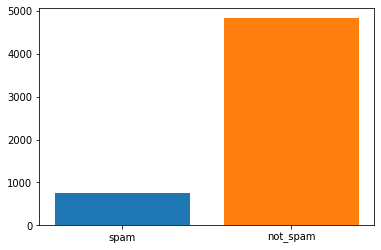

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.bar(SPAM, len(parsed_lines[SPAM]))
plt.bar(NOT_SPAM, len(parsed_lines[NOT_SPAM]))
plt.show()

Используем pandas, чтобы удобно смотреть данные

In [41]:
import pandas as pd
LABEL = 'label'
MSG = 'message'

Объединяем dict parsed_lines, чтобы записать в таблицу. Паралелльно чистим текст

In [44]:
def clean_text(text):
    return text.replace(r"http\S+", "") \
      .replace(r"http", "") \
      .replace(r"@\S+", "") \
      .replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ") \
      .replace(r"@", "at").lower()

import random
data_table = []
for spam_line in parsed_lines[SPAM]:
  data_table.append({LABEL: SPAM, MSG: clean_text(spam_line)})
for not_spam_line in parsed_lines[NOT_SPAM]:
  data_table.append({LABEL: NOT_SPAM, MSG: clean_text(not_spam_line)})
random.shuffle(data_table)

In [46]:
df = pd.DataFrame(data_table)
df

,label,message
0,not_spam,also tell him i said happy birthday
1,not_spam,hi. i'm sorry i missed your call. can you pls ...
2,not_spam,"ill call u 2mrw at ninish, with my address tha..."
3,not_spam,i called but no one pick up e phone. i ask bot...
4,not_spam,arun can u transfr me d amt
...,...,...
5569,not_spam,oh that was a forwarded message. i thought you...
5570,not_spam,ron say fri leh. n he said ding tai feng cant ...
5571,not_spam,i'm sick !! i'm needy !! i want you !! *pouts*...
5572,not_spam,cthen i thk shd b enuff.. still got conclusion...


In [47]:
df.groupby(LABEL).count()

,message
label,
not_spam,4827
spam,747


Токенизируем текст

In [50]:
from nltk.tokenize import RegexpTokenizer

TOKENS = 'tokens'
tokenizer = RegexpTokenizer(r'\w+')

df[TOKENS] = df[MSG].apply(tokenizer.tokenize)
df.head()

,label,message,tokens
0,not_spam,also tell him i said happy birthday,"[also, tell, him, i, said, happy, birthday]"
1,not_spam,hi. i'm sorry i missed your call. can you pls ...,"[hi, i, m, sorry, i, missed, your, call, can, ..."
2,not_spam,"ill call u 2mrw at ninish, with my address tha...","[ill, call, u, 2mrw, at, ninish, with, my, add..."
3,not_spam,i called but no one pick up e phone. i ask bot...,"[i, called, but, no, one, pick, up, e, phone, ..."
4,not_spam,arun can u transfr me d amt,"[arun, can, u, transfr, me, d, amt]"


Немного больше информации о тексте, а именно длина сообщения

In [55]:
all_words = [word for tokens in df[TOKENS] for word in tokens]
sentence_lengths_spam = [len(tokens) for tokens in df.loc[df[LABEL] == SPAM][TOKENS]]
sentence_lengths_not_spam = [len(tokens) for tokens in df.loc[df[LABEL] == NOT_SPAM][TOKENS]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(max(sentence_lengths), max(sentence_lengths_not_spam)))

90357 words total, with a vocabulary size of 8757
Max sentence length is 190


Ещё один красивый графичек, красивых графичков много не бывает

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


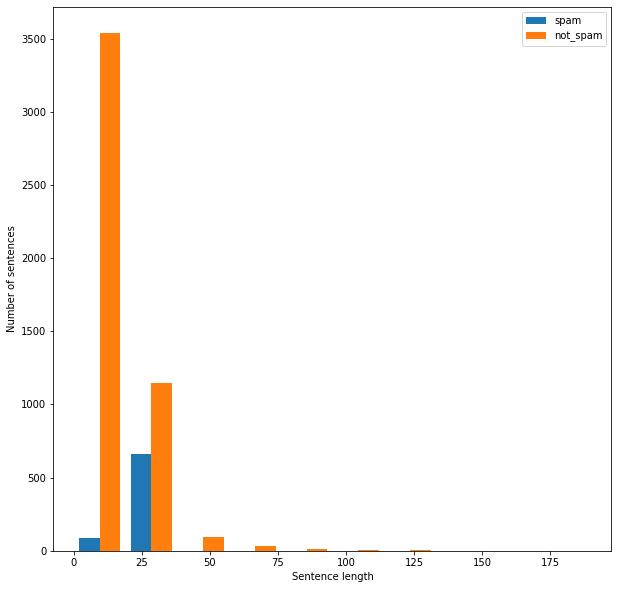

In [64]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist([sentence_lengths_spam, sentence_lengths_not_spam], label=[SPAM, NOT_SPAM])
plt.legend()
plt.show()

Как видим большинство сообщений короткие, поэтому трудно сказать, но у спама только короткие

Обычный LabelEncoder сюда не подойдет (ну можно, но сложно), воспользуемся CountVectorizer

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()

In [126]:
list_corpus = df[MSG].tolist()
list_labels = df[LABEL].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train = count_vectorizer.fit_transform(X_train)
X_test = count_vectorizer.transform(X_test)
print(count_vectorizer.vocabulary_)

{'text': 6799, 'pass': 5119, 'to': 6946, '69669': 601, 'collect': 1932, 'your': 7732, 'polyphonic': 5328, 'ringtones': 5812, 'normal': 4854, 'gprs': 3234, 'charges': 1774, 'apply': 1046, 'only': 4973, 'enjoy': 2622, 'tones': 6973, 'yun': 7745, 'ah': 887, 'now': 4873, 'wkg': 7574, 'where': 7499, 'btw': 1574, 'if': 3620, 'go': 3182, 'nus': 4892, 'sc': 5949, 'wana': 7391, 'specialise': 6380, 'in': 3663, 'wad': 7362, 'all': 929, 'done': 2440, 'handed': 3336, 'don': 2438, 'know': 3985, 'mega': 4455, 'shop': 6131, 'asda': 1111, 'counts': 2074, 'as': 1108, 'celebration': 1741, 'but': 1609, 'thats': 6825, 'what': 7488, 'doing': 2429, 'send': 6030, 'logo': 4206, 'ur': 7212, 'lover': 4259, 'names': 4720, 'joined': 3864, 'by': 1623, 'heart': 3403, 'txt': 7105, 'love': 4254, 'name1': 4717, 'name2': 4718, 'mobno': 4577, 'eg': 2568, 'adam': 825, 'eve': 2677, '07123456789': 23, '87077': 707, 'yahoo': 7691, 'pobox36504w45wq': 5302, 'txtno': 7112, 'no': 4825, 'ads': 843, '150p': 310, 'me': 4433, 'not':

Попробуем сначала логистическую регрессию

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

    not_spam       0.98      1.00      0.99       944
        spam       0.99      0.91      0.95       171

    accuracy                           0.98      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.98      0.98      0.98      1115



In [120]:
index_to_word = {v: k for k, v in count_vectorizer.vocabulary_.items()}
importance = {}
n = 10
for class_index in range(clf.coef_.shape[0]):
    word_importances = [(el, index_to_word[i]) for i, el in enumerate(clf.coef_[class_index])]
    sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
    tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
    bottom = sorted_coeff[-n:]
    importance[class_index] = {
        'tops':tops,
        'bottom':bottom
    }
importance

{0: {'bottom': [(-0.6589783349202162, 'he'),
   (-0.6630154405926928, 'sorry'),
   (-0.6653604606407169, 'but'),
   (-0.6667398929149457, 'hope'),
   (-0.682795726467272, 'going'),
   (-0.7850586649753015, 'sir'),
   (-0.9207664282455378, 'me'),
   (-0.9789345492831126, 'lt'),
   (-1.0051612852709304, 'my'),
   (-1.0293303050628264, 'gt')],
  'tops': [(1.3685832455537976, 'service'),
   (1.405119875584181, 'reply'),
   (1.442698546187682, 'won'),
   (1.4767568446132346, 'chat'),
   (1.5028744409399957, 'new'),
   (1.5796905153197272, 'text'),
   (1.6088232159943336, 'call'),
   (1.6382361666266052, 'ringtone'),
   (1.6450234746852814, 'uk'),
   (1.9029941044637417, 'txt')]}}

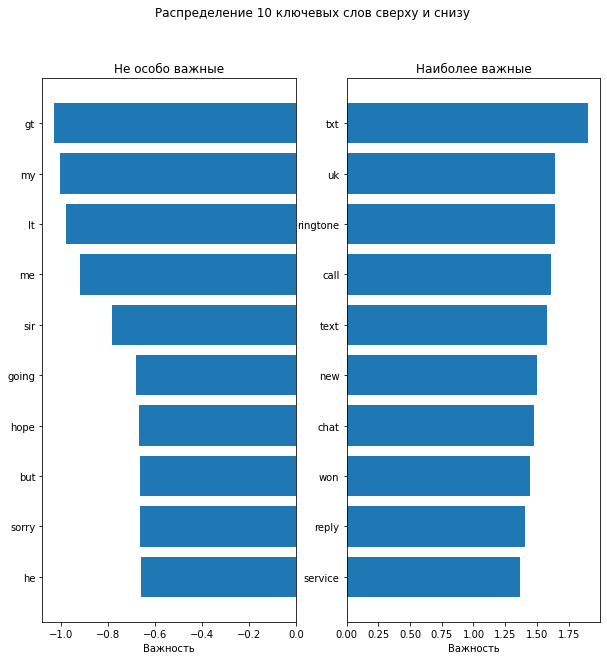

In [121]:
import numpy as np

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

y_pos = np.arange(len(top_words))
top_pairs = zip(top_words, top_scores)
top_pairs = sorted(top_pairs, key=lambda x: x[1])

bottom_pairs = zip(bottom_words, bottom_scores)
bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

fig = plt.figure(figsize=(10, 10))  

plt.subplot(121)
plt.barh(y_pos,bottom_scores)
plt.title('Не особо важные')
plt.yticks(y_pos, bottom_words)
plt.suptitle('Ключевые слова')
plt.xlabel('Важность')

plt.subplot(122)
plt.barh(y_pos,top_scores)
plt.title('Наиболее важные')
plt.yticks(y_pos, top_words)
plt.suptitle('Распределение 10 ключевых слов сверху и снизу')
plt.xlabel('Важность')
plt.show()

Можно увидеть справа слово 'won', что может означать "выигрыш" в какой-либо лотерее или игре, что конечно же является спамом.

Теперь попробуем Байеса

In [128]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

mnb.fit(X_train, y_train)
y_train_predict = mnb.predict(X_train)
y_predict = mnb.predict(X_test)

print("Результаты для тренировочной выборки")
print(classification_report(y_train, y_train_predict))
print("Результаты для тестовой выборки")
print(classification_report(y_test, y_predict))

Результаты для тренировочной выборки
              precision    recall  f1-score   support

    not_spam       1.00      1.00      1.00      3883
        spam       0.99      0.97      0.98       576

    accuracy                           0.99      4459
   macro avg       0.99      0.98      0.99      4459
weighted avg       0.99      0.99      0.99      4459

Результаты для тестовой выборки
              precision    recall  f1-score   support

    not_spam       0.99      1.00      0.99       944
        spam       0.98      0.93      0.95       171

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



Видно, что Байес сработал немного лучше, чем логистическая регрессия

In [139]:
index_to_word = {v: k for k, v in count_vectorizer.vocabulary_.items()}
importance = {}
n = 10
for class_index in range(mnb.coef_.shape[0]):
    word_importances = [(el, index_to_word[i]) for i, el in enumerate(mnb.coef_[class_index])]
    sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
    tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
    bottom = sorted_coeff[-n:]
    importance[class_index] = {
        'tops':tops,
        'bottom':bottom
    }
importance

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


{0: {'bottom': [(-9.963358949573518, 'yupz'),
   (-9.963358949573518, 'zac'),
   (-9.963358949573518, 'zaher'),
   (-9.963358949573518, 'zealand'),
   (-9.963358949573518, 'zhong'),
   (-9.963358949573518, 'zindgi'),
   (-9.963358949573518, 'zogtorius'),
   (-9.963358949573518, 'zoom'),
   (-9.963358949573518, 'zyada'),
   (-9.963358949573518, 'èn')],
  'tops': [(-5.167568403976777, 'txt'),
   (-4.9264063471598885, 'for'),
   (-4.9264063471598885, 'now'),
   (-4.8944547473532865, 'or'),
   (-4.888185134339691, 'the'),
   (-4.804303650358989, 'free'),
   (-4.635482780783937, 'your'),
   (-4.512320496007818, 'you'),
   (-4.3502308431854475, 'call'),
   (-3.6961584010321555, 'to')]}}

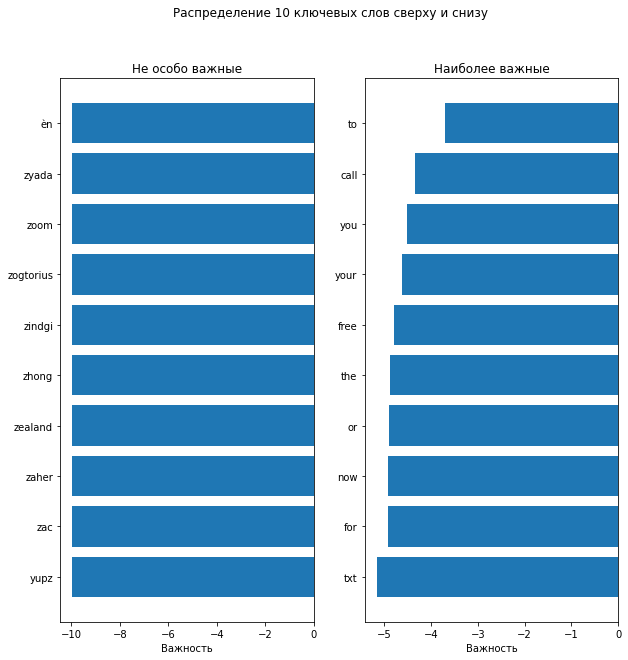

In [140]:
import numpy as np

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

y_pos = np.arange(len(top_words))
top_pairs = zip(top_words, top_scores)
top_pairs = sorted(top_pairs, key=lambda x: x[1])

bottom_pairs = zip(bottom_words, bottom_scores)
bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

fig = plt.figure(figsize=(10, 10))  

plt.subplot(121)
plt.barh(y_pos,bottom_scores)
plt.title('Не особо важные')
plt.yticks(y_pos, bottom_words)
plt.suptitle('Ключевые слова')
plt.xlabel('Важность')

plt.subplot(122)
plt.barh(y_pos,top_scores)
plt.title('Наиболее важные')
plt.yticks(y_pos, top_words)
plt.suptitle('Распределение 10 ключевых слов сверху и снизу')
plt.xlabel('Важность')
plt.show()